<a href="https://colab.research.google.com/github/mjmousavi97/Deep-Learning-Tehran-uni/blob/main/HomeWorks/05%20HW/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import files
import zipfile
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow as tf

In [3]:
uploaded = files.upload()

Saving Annotations.zip to Annotations (1).zip
Saving Images.zip to Images (1).zip


In [4]:
with zipfile.ZipFile('/content/Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [5]:
with zipfile.ZipFile('/content/Annotations.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [6]:
file_name = 'airplane_440'
img = cv2.imread(os.path.join('/content/Images/Images/', file_name + '.jpg'))

In [7]:
df = pd.read_csv(os.path.join('/content/Airplanes_Annotations/',  file_name + '.csv'))

In [8]:
df

,1
0,115 53 219 156


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

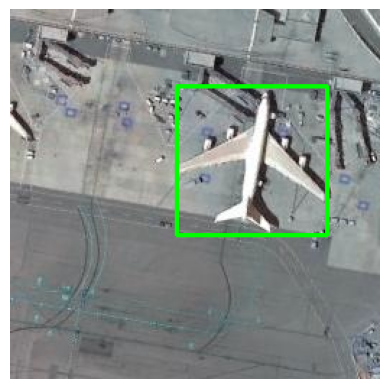

In [9]:
for i, row in df.iterrows():
    _, row = next(row.items())

    x1 = int(row.split(' ')[0])
    y1 = int(row.split(' ')[1])
    x2 = int(row.split(' ')[2])
    y2 = int(row.split(' ')[3])

    cv2.rectangle(img=img, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=2)

plt.figure()
plt.imshow(img)
plt.axis('off')


# **Intersection of Union**

In [10]:
def iou_calc(box1: dict, box2: dict) -> float:
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Each box should be a dictionary with keys:
        'x1', 'y1' -> coordinates of the top-left corner
        'x2', 'y2' -> coordinates of the bottom-right corner

    Returns a float between 0.0 and 1.0 representing how much the boxes overlap.
    If they don't overlap at all, returns 0.0.

    Example:
        box_a = {'x1': 0, 'y1': 0, 'x2': 2, 'y2': 2}
        box_b = {'x1': 1, 'y1': 1, 'x2': 3, 'y2': 3}
        iou_calc(box_a, box_b)  # returns 0.142857...
    """
    x1 = max(box1['x1'], box2['x1'])
    y1 = max(box1['y1'], box2['y1'])
    x2 = min(box1['x2'], box2['x2'])
    y2 = min(box1['y2'], box2['y2'])

    if x2 < x1 or y2 < y1:
        return 0.0

    intersection_area = (x2 - x1) * (y2 - y1)

    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])
    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou


In [11]:
box_a = {'x1': 0, 'y1': 0, 'x2': 2, 'y2': 2}
box_b = {'x1': 1, 'y1': 1, 'x2': 3, 'y2': 3}

iou_calc(box_a, box_b)

0.14285714285714285

# **Selective Search**
It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

Number of selected proposals: 572


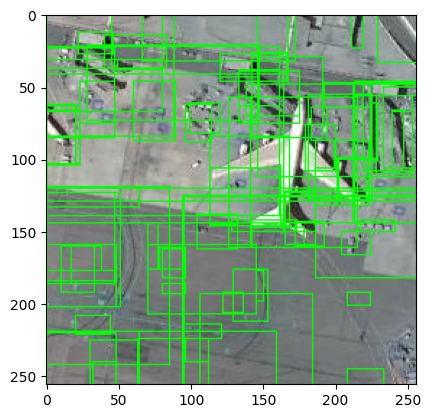

In [31]:
file_name = 'airplane_440'
img = cv2.imread(os.path.join('/content/Images/Images/', file_name + '.jpg'))
image_copy = img.copy()  # make a copy to draw on

# create selective search object and set image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image_copy)
ss.switchToSelectiveSearchFast()  # quick mode (less accurate but faster)

rects = ss.process()  # list of region proposals (x, y, w, h)
print(f'Number of selected proposals: {rects.shape[0]}')

# draw the 100 proposals on image
for idx, rect in enumerate(rects[:100, :]):
    x1, y1, w, h = rect
    x2, y2 = x1 + w, y1 + h
    cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.imshow(image_copy)  # show image with drawn box


In [ ]:
class DataGenerator(keras.utils.Sequence):
    pass